### Importing all the required libraries

In [184]:
import pandas as pd
import numpy as np
#Importing libraries
import pandas as pd # Pandas library to create dataframe
import warnings # To ignore depreciation warning 
warnings.filterwarnings('ignore')
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler # Standard Scaling Library
from sklearn.decomposition import PCA # From Sklearn.decompostion API import PCA
from sklearn.model_selection import train_test_split

### Reading the dataset from the files

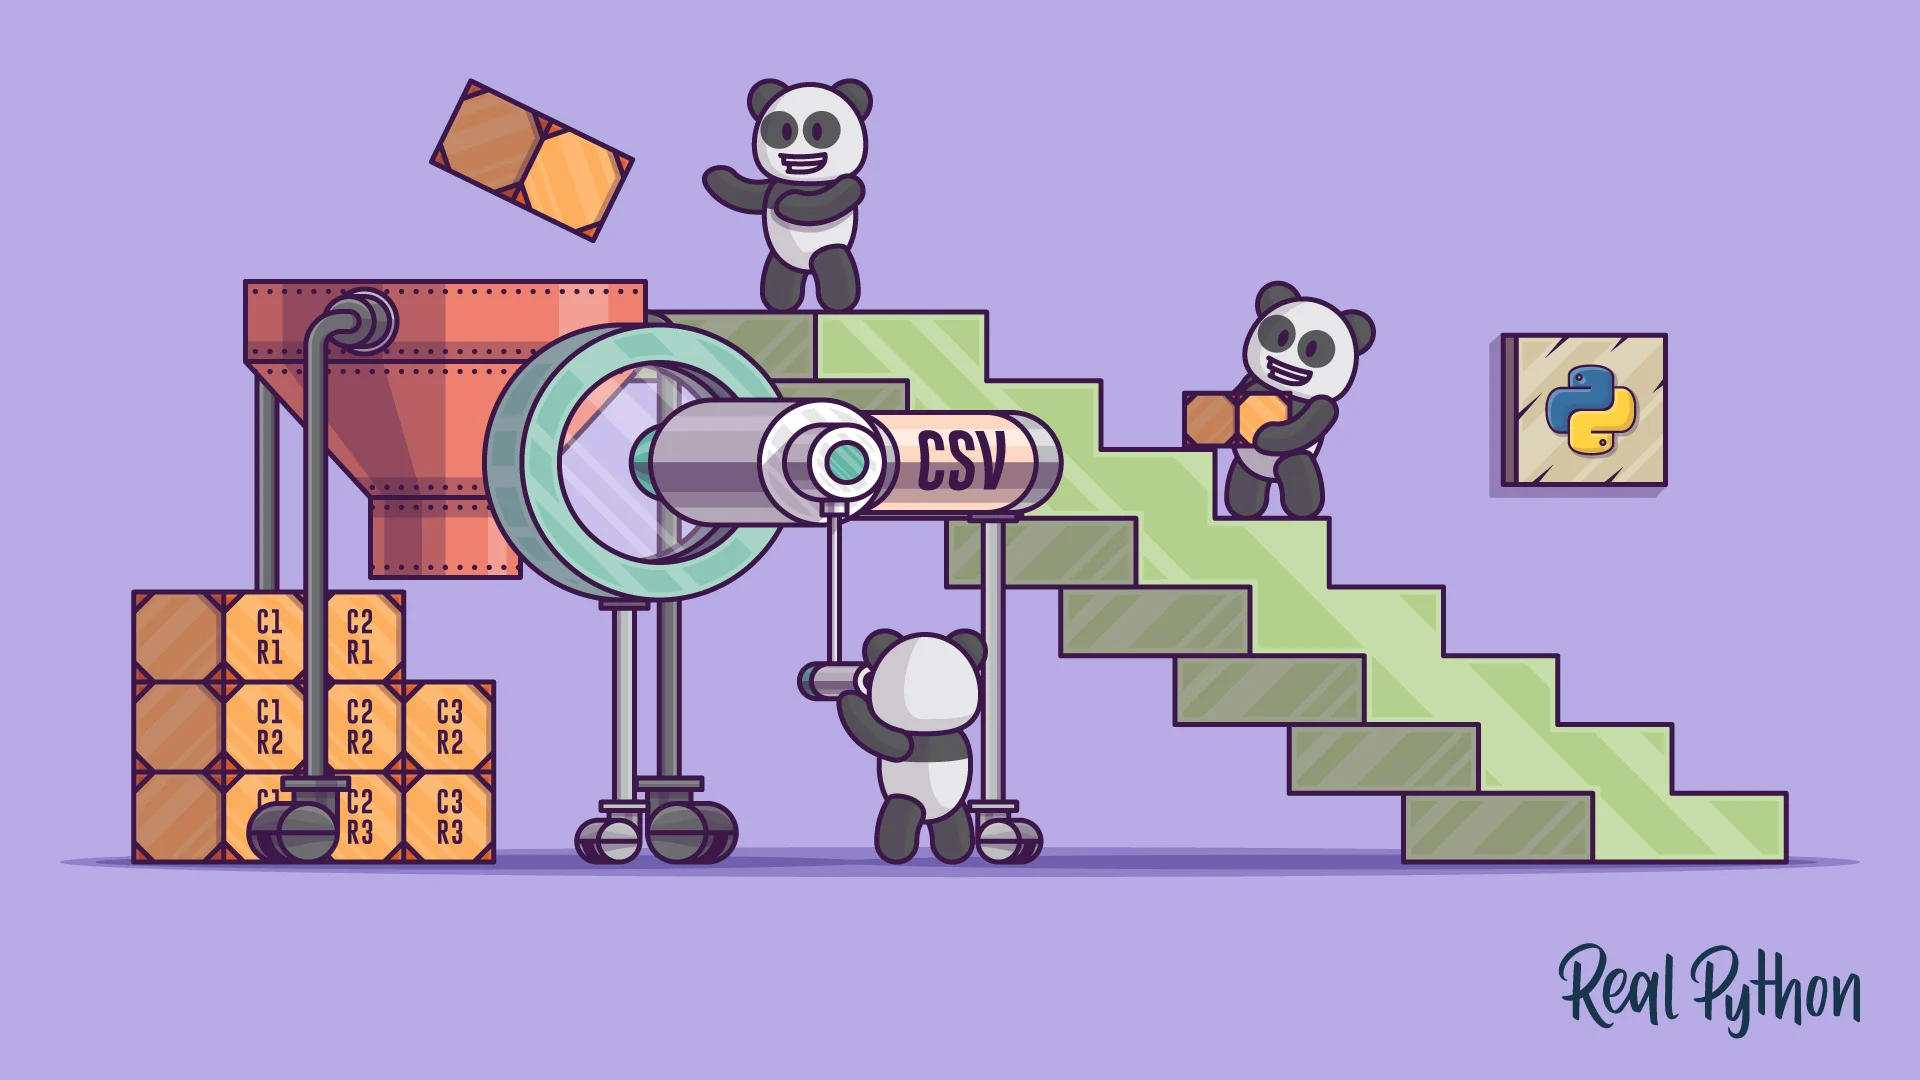

In [185]:
# Text Cleaning
## Read the File First
train_file = "1646012055_4106488_train.txt"
test_file = "1646012055_420069_test.txt"


df = pd.read_csv(train_file, header=None, sep='\t', index_col=False, names=["target", "data"], )
target = df["target"]
df = df["data"].str.split(' ', expand=True)
X = df.apply(pd.to_numeric)
X = X.iloc[:,:4858]
y = target.apply(pd.to_numeric)

only the first 4858 columns were selected in the dataset because in the trainig data has only 4858 columns

#### Feature selection

##### What is feature selection ?
Feature selection is the process of reducing the number of input variables when developing a predictive model. It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model.

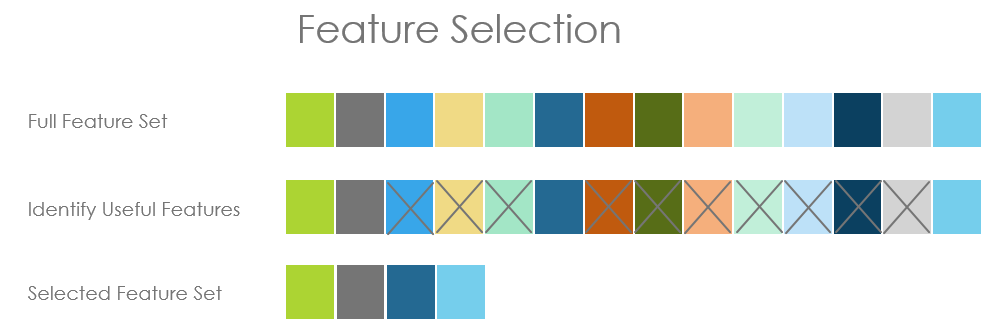

##### Lets visualize the shape and Quantity of data

In [189]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,4848,4849,4850,4851,4852,4853,4854,4855,4856,4857
0,191,367,614,634,711,1202,1220,1311,1472,1730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,118,307,367,478,505,512,807,878,939,1024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,184,284,297,320,375,445,588,658,1108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,87,149,433,704,711,892,988,1056,1070,1234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84,118,279,316,435,505,584,629,849,1029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [190]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

#### Lets plot histogram to visualize the frequency of the output class

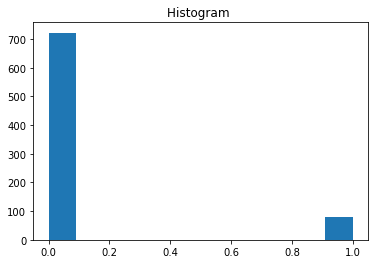

In [191]:
import matplotlib.pyplot as plt
_ = plt.hist(y.to_list(), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram ")
plt.show()

#### High class imbalance observed in the dataset

##### Moving to fetaure selection

##### Feature selection using SVM / Trees / Chi2

In [192]:
def feature_selection(X,y,method):
    from sklearn.svm import LinearSVC
    from sklearn.feature_selection import SelectFromModel
    from sklearn.ensemble import ExtraTreesClassifier
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import chi2
    X = X.fillna(0)
    if method == 'SVM':
        lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
        model = SelectFromModel(lsvc, prefit=True)
        X_SVC = model.transform(X)
        return X_SVC , y
    if method == 'Trees':
        clf = ExtraTreesClassifier(n_estimators=50)
        clf = clf.fit(X, y)
        # clf.feature_importances_  
        model = SelectFromModel(clf, prefit=True)
        X_tree = model.transform(X)
        return X_tree,y 
    if method == 'chi2':
        X_chi = SelectKBest(chi2, k=100).fit_transform(X, y)
        return X_chi , y 
    return 'please input a valid method option'
    

In [193]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from time import perf_counter
from sklearn.metrics import precision_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import sklearn

#### Synthetic Over-sampling

Synthetic over-sampling is illustrate din the diagram above

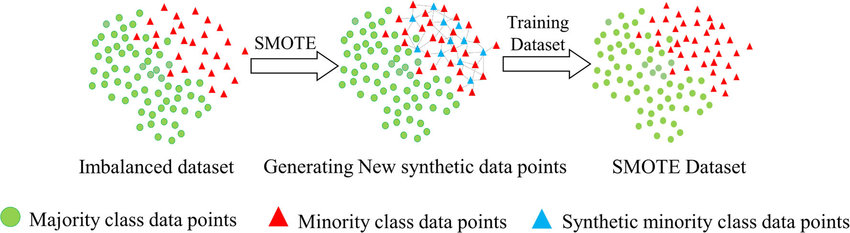

Standardization and normalization are not performed because from the data-set. I am focusing on tree-based methods and those methods are in-sensitive to standardization techniques

In [194]:
X = X.fillna(0)
y = y.fillna(0)
oversample = SMOTE(sampling_strategy='minority')
X, y = oversample.fit_resample(X, y)

#### Featre selection from SVM and train / test/ split

## Feature selection using Linear SVM 

In [195]:
X_featured, Y_featured = feature_selection(X,y,method = 'SVM')
X_train, X_test, y_train, y_test = train_test_split(X_featured, y, test_size=0.1, random_state=42)
# Handling NAN values

Linear models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero. When the goal is to reduce the dimensionality of the data to use with another classifier, they can be used along with SelectFromModel to select the non-zero coefficients. In particular, sparse estimators useful for this purpose are the Lasso for regression, and of LogisticRegression and LinearSVC for classification:

#### Model training from features selected from Linear SVM

In [196]:
models = { "Random Forest": {"model": RandomForestClassifier(), "perf": 0},
            "Gradient Boosting": {"model": GradientBoostingClassifier(), "perf": 0},
            "XGBoost": {"model": XGBClassifier(eval_metric='mlogloss'), "perf": 0},
            "Logistic Regr.": {"model": LogisticRegression(), "perf": 0},
            "KNN": {"model": KNeighborsClassifier(), "perf": 0},
            "Decision Tree": {"model": DecisionTreeClassifier(), "perf": 0},
            "SVM (Linear)": {"model": LinearSVC(), "perf": 0},
            "Bagging Classifier": {"model": BaggingClassifier(), "perf": 0}
          }

for name, model in models.items():
    start = perf_counter()
    model['model'].fit(X_train, y_train)
    duration = perf_counter() - start
    duration = round(duration, 2)
    model["perf"] = duration
    print('The classification report of ' +str(name) )
    print(sklearn.metrics.classification_report(y_test, model['model'].predict(X_test)))


The classification report of Random Forest
              precision    recall  f1-score   support

           0       0.99      0.91      0.94        74
           1       0.91      0.99      0.95        71

    accuracy                           0.94       145
   macro avg       0.95      0.95      0.94       145
weighted avg       0.95      0.94      0.94       145

The classification report of Gradient Boosting
              precision    recall  f1-score   support

           0       0.97      0.80      0.87        74
           1       0.82      0.97      0.89        71

    accuracy                           0.88       145
   macro avg       0.89      0.88      0.88       145
weighted avg       0.90      0.88      0.88       145

The classification report of XGBoost
              precision    recall  f1-score   support

           0       0.97      0.88      0.92        74
           1       0.88      0.97      0.93        71

    accuracy                           0.92       145
 

## Feature selection using  L1-based feature selection 

In [197]:
X_featured, Y_featured = feature_selection(X,y,method = 'chi2')
X_train, X_test, y_train, y_test = train_test_split(X_featured, y, test_size=0.1, random_state=42)
# Handling NAN values

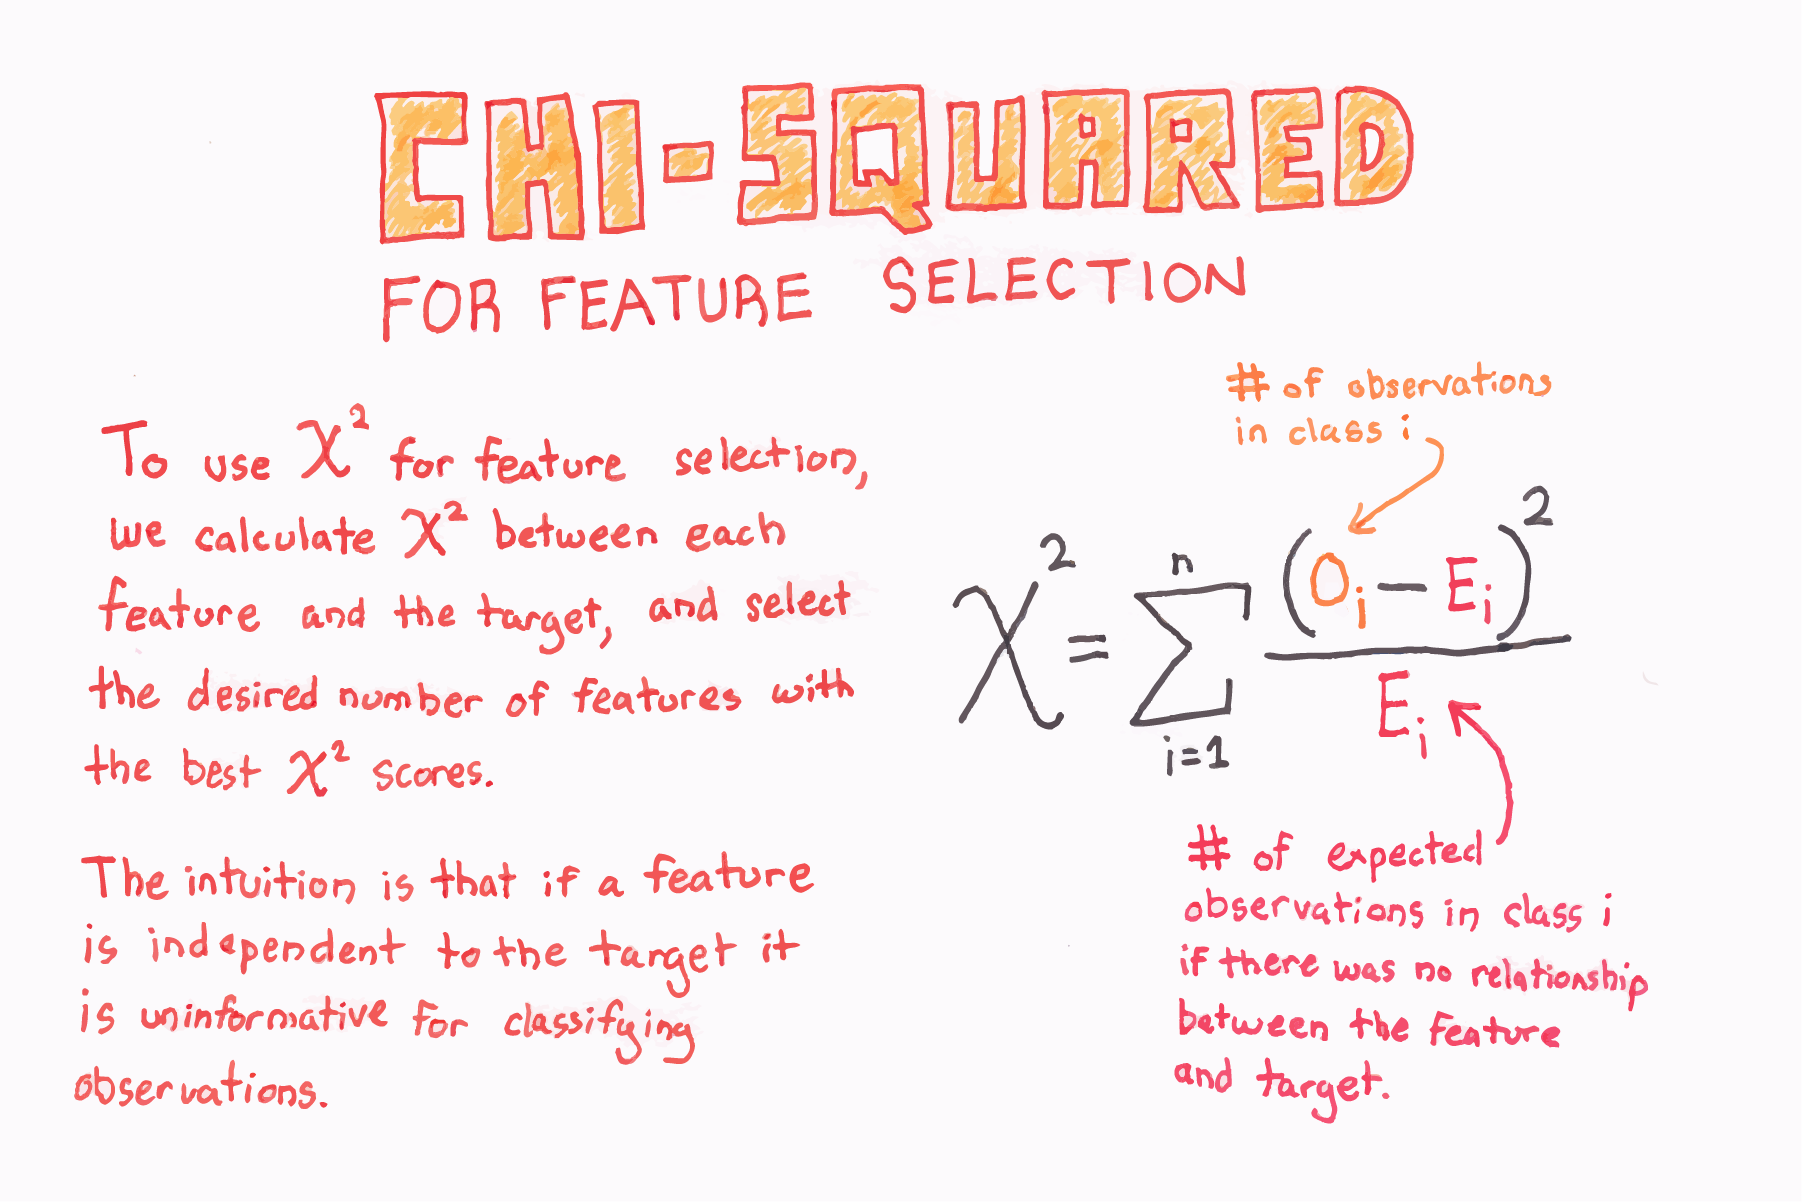

#### Model training from features selected from L1-Based Features

In [198]:
models = { "Random Forest": {"model": RandomForestClassifier(), "perf": 0},
            "Gradient Boosting": {"model": GradientBoostingClassifier(), "perf": 0},
            "XGBoost": {"model": XGBClassifier(eval_metric='mlogloss'), "perf": 0},
            "Logistic Regr.": {"model": LogisticRegression(), "perf": 0},
            "KNN": {"model": KNeighborsClassifier(), "perf": 0},
            "Decision Tree": {"model": DecisionTreeClassifier(), "perf": 0},
            "SVM (Linear)": {"model": LinearSVC(), "perf": 0},
            "Bagging Classifier": {"model": BaggingClassifier(), "perf": 0}
          }

for name, model in models.items():
    start = perf_counter()
    model['model'].fit(X_train, y_train)
    duration = perf_counter() - start
    duration = round(duration, 2)
    model["perf"] = duration
    print('The classification report of ' +str(name) )
    print(sklearn.metrics.classification_report(y_test, model['model'].predict(X_test)))

       

The classification report of Random Forest
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        74
           1       1.00      0.10      0.18        71

    accuracy                           0.56       145
   macro avg       0.77      0.55      0.44       145
weighted avg       0.76      0.56      0.44       145

The classification report of Gradient Boosting
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        74
           1       1.00      0.10      0.18        71

    accuracy                           0.56       145
   macro avg       0.77      0.55      0.44       145
weighted avg       0.76      0.56      0.44       145

The classification report of XGBoost
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        74
           1       1.00      0.10      0.18        71

    accuracy                           0.56       145
 

## Feature Selection using Tree based methods
Tree-based estimators can be used to compute impurity-based feature importances, which in turn can be used to discard irrelevant features 




In [199]:
X_featured, Y_featured = feature_selection(X,y,method = 'Trees')
X_train, X_test, y_train, y_test = train_test_split(X_featured, y, test_size=0.1, random_state=42)
# Handling NAN values

In [200]:
models = { "Random Forest": {"model": RandomForestClassifier(), "perf": 0},
            "Gradient Boosting": {"model": GradientBoostingClassifier(), "perf": 0},
            "XGBoost": {"model": XGBClassifier(eval_metric='mlogloss'), "perf": 0},
            "Logistic Regr.": {"model": LogisticRegression(), "perf": 0},
            "KNN": {"model": KNeighborsClassifier(), "perf": 0},
            "Decision Tree": {"model": DecisionTreeClassifier(), "perf": 0},
            "SVM (Linear)": {"model": LinearSVC(), "perf": 0},
            "Bagging Classifier": {"model": BaggingClassifier(), "perf": 0}
          }

for name, model in models.items():
    start = perf_counter()
    model['model'].fit(X_train, y_train)
    duration = perf_counter() - start
    duration = round(duration, 2)
    model["perf"] = duration
    print('The classification report of ' +str(name) )
    print(sklearn.metrics.classification_report(y_test, model['model'].predict(X_test)))

The classification report of Random Forest
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        74
           1       0.97      0.96      0.96        71

    accuracy                           0.97       145
   macro avg       0.97      0.97      0.97       145
weighted avg       0.97      0.97      0.97       145

The classification report of Gradient Boosting
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        74
           1       0.86      0.94      0.90        71

    accuracy                           0.90       145
   macro avg       0.90      0.90      0.90       145
weighted avg       0.90      0.90      0.90       145

The classification report of XGBoost
              precision    recall  f1-score   support

           0       0.96      0.91      0.93        74
           1       0.91      0.96      0.93        71

    accuracy                           0.93       145
 

#### Analyzing the F-1 Score.

what is F1-Score ?

F1 score is defined as the harmonic mean between precision and recall. It is used as a statistical measure to rate performance. In other words, an F1-score (from 0 to 9, 0 being lowest and 9 being the highest) is a mean of an individual's performance, based on two factors i.e. precision and recall

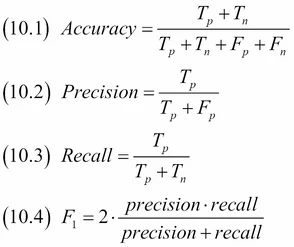


From the above classification reports. The F1-Score on the minority class with the classifiers Random Forest and XGboost Seems to perfrom the best 

## ROC CURVE

What is ROC curve ? 

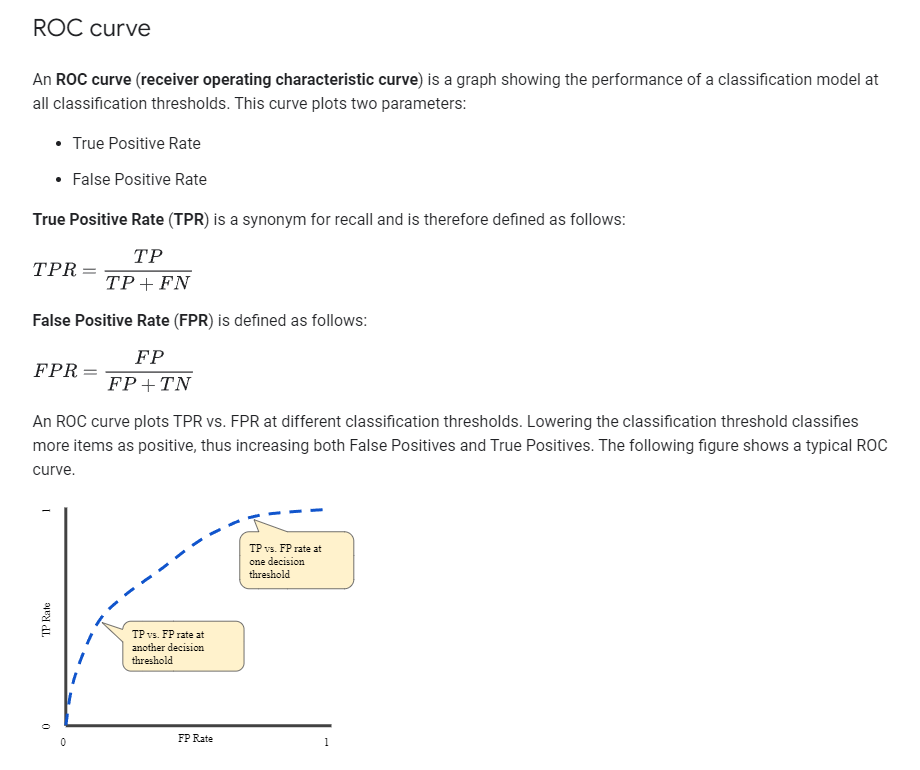

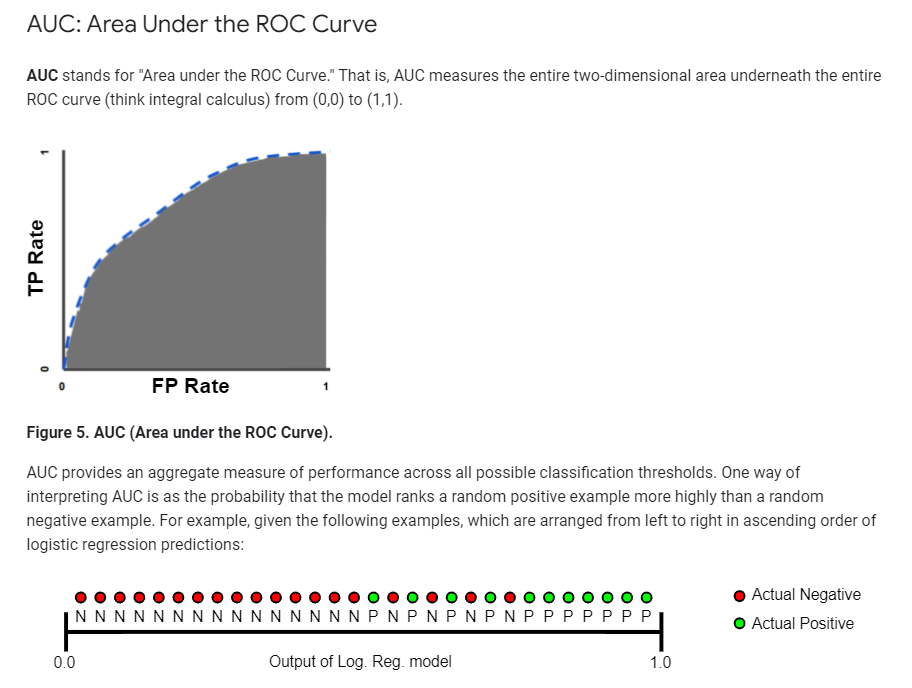

### Analyzing the ROC curve of Random forest and XGboost

Random Forest

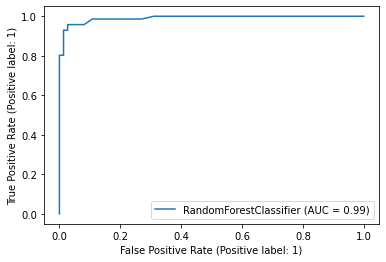

In [201]:
import matplotlib.pyplot as plt

clf = RandomForestClassifier()
clf.fit(X_train,y_train)

sklearn.metrics.plot_roc_curve(clf, X_test, y_test) 
plt.show()

Xgboost

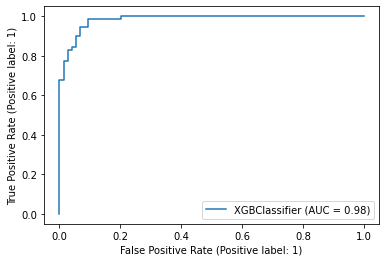

In [202]:
import matplotlib.pyplot as plt

clf = XGBClassifier(eval_metric='mlogloss')
clf.fit(X_train,y_train)

sklearn.metrics.plot_roc_curve(clf, X_test, y_test) 
plt.show()

The area under the surve is same for the both classifiers but visually Random forest seems to be better

## Prediction on the training data given in seperate file

LOADING DATASET

In [214]:
# Text Cleaning
## Read the File First
train_file = "1646012055_4106488_train.txt"
test_file = "1646012055_420069_test.txt"


df = pd.read_csv(train_file, header=None, sep='\t', index_col=False, names=["target", "data"], )
target = df["target"]
df = df["data"].str.split(' ', expand=True)
X = df.apply(pd.to_numeric)
X = X.iloc[:,:4858]
y = target.apply(pd.to_numeric)

OVERSAMPLING THE MINORITY CLASS

In [215]:
oversample = SMOTE(sampling_strategy='minority')
X = X.fillna(0)
y = y.fillna(0)
X, y = oversample.fit_resample(X, y)

In [216]:
df_test = pd.read_csv(test_file, header=None, sep='\t', index_col=False , names=["data"])
X_TEST = df_test["data"].str.split(' ', expand=True)
X_TEST = X_TEST.fillna(0)
X_TEST  =  X_TEST.apply(pd.to_numeric)
print('The shape of test data')
print(X_TEST.shape)
print('The shape of trainin data')
print(X.shape)

The shape of test data
(350, 4858)
The shape of trainin data
(1444, 4858)


In [217]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
print('shape before feature selection')
print(X.shape)
# clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_tree = model.transform(X)
print('Shape after feature selection')
print(X_tree.shape)
### Feature selection done 
## During now we shall not train test split but rather train on whle data and do prediction on the data from the seperate file
# Tranforming the test data in the same way as the training data
X_TEST = X_TEST.fillna(0)
X_TEST = model.transform(X_TEST)

clf = RandomForestClassifier()
clf.fit(X_tree,y)


# Prediction on the test 

X_TEST_PRED = clf.predict(X_TEST) 


shape before feature selection
(1444, 4858)
Shape after feature selection
(1444, 1048)


### Writing predictions to a file 

In [220]:
f = open("predictions.txt", "a")
for value in X_TEST_PRED :
    f.write(str(value))
f.close()

### Saving the best model

In [222]:
import joblib
filename = 'finalized_model.sav'
joblib.dump(clf, filename)

['finalized_model.sav']

How to load the model ?

import joblib

loaded_model = joblib.load('finalized_model.sav')

#### Making the prediction

output = loaded_model.predict(input_data)

### Conclusion/Analysis

A binary classification dataset was given. The dataset has lots of input features i.e. 6062. Feature selection techniques wee applied to choose the most appropirate features. 3 features selection techniques were applied and all the models including

1. Random Forest
2. SVM
3. Gradient Boosting
4. KNN
5. Decision Tree
6. Logistic Rgression
7. Bagging classifier

The best feature selection method based on the F1-score was Trees based selection. A detailed documentation abut the method could be seen at:
https://scikit-learn.org/stable/modules/feature_selection.html

Synthetic data generation was applied on the dataset to solved the problem of data imbalance. The data imbalance was solved using SMOTE technique. The detailed implementtaion of theSMOTE could be found at:

https://arxiv.org/abs/1106.1813.

The best classifiers based on the F1 score of the 1 label class were XGBOOST and Random Forest. These two classifiers were further analyzed using the ROC curve. The Random Forest had a visually more appealing graph and it was selected as final algorithm.